# Import

In [2]:
import os

from datasets import load_dataset

from modelscope.metainfo import Trainers
from modelscope.msdatasets import MsDataset
from modelscope.preprocessors.audio import AudioBrainPreprocessor
from modelscope.trainers import build_trainer
from modelscope.utils.audio.audio_utils import to_segment
from modelscope import HubApi
#api=HubApi()
#api.login('ms-fd061f57-04cb-489f-b804-13386174b209')
#from torchmetrics import SignalDistortionRatio,ScaleInvariantSignalNoiseRatio, PermutationInvariantTraining
import torchaudio
import random
import subprocess
import shutil
import numpy  as np
import soundfile as sf
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
import torch
#from torchmetrics.functional.audio import scale_invariant_signal_noise_ratio
import itertools
##import matplotlib.pyplot as plt
##from matplotlib.backends.backend_pdf import PdfPages


/home/khapham/.conda/envs/mossformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-11 11:11:29,811 - modelscope - INFO - PyTorch version 2.8.0 Found.
2025-11-11 11:11:29,812 - modelscope - INFO - Loading ast index from /home/khapham/.cache/modelscope/ast_indexer
2025-11-11 11:11:29,899 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 3c64a03cabeec8766eab008566f93a88 and a total number of 945 components indexed


# Resample Wav Files

In [13]:

root_dir = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data"

for i in range(1000):
    folder_name = f"eng_mix_{i:04d}"
    folder_path = os.path.join(root_dir, folder_name)
    fine_tuning_folder = os.path.join(folder_path, f"ft_{i:04d}")
    os.makedirs(fine_tuning_folder, exist_ok=True)

    input_wav = os.path.join(folder_path, f"{folder_name}.wav")
    output_wav = os.path.join(fine_tuning_folder, f"{folder_name}_16k.wav")

    if not os.path.exists(input_wav):
        print(f"Bỏ qua {input_wav} (không tồn tại)")
        continue

    # Gọi ffmpeg để resample về 16kHz, mono
    cmd = [
        "ffmpeg",
        "-y",                # ghi đè nếu file đã tồn tại
        "-i", input_wav,     # file đầu vào
        "-ar", "16000",      # sample rate 16kHz
        "-ac", "1",          # mono
        output_wav           # file đầu ra
    ]

    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    print(f"Đã resample: {output_wav}")


Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0000/ft_0000/eng_mix_0000_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0001/ft_0001/eng_mix_0001_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0002/ft_0002/eng_mix_0002_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0003/ft_0003/eng_mix_0003_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0004/ft_0004/eng_mix_0004_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0005/ft_0005/eng_mix_0005_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data/eng_mix_0006/ft_0006/eng_mix_0006_16k.wav
Đã resample: /mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Data

# Mix 2 wav files

In [ ]:
data_folder_path = 'datalocnhieu_onlywav'
output_folder_path = 'mix_data_locnhiet'
os.makedirs(output_folder_path, exist_ok=True)

samples = 2000
files = [f for f in os.listdir(data_folder_path) if f.endswith(".wav")]

for i in range(samples):
    v1, v2 = random.sample(files, 2)

    destination_folder = os.path.join(output_folder_path, f"mix_{i:04d}")
    os.makedirs(destination_folder, exist_ok=True)

    src1 = os.path.join(data_folder_path, v1)
    src2 = os.path.join(data_folder_path, v2)

    resampled1 = os.path.join(destination_folder, f"source1_{i:04d}.wav")
    resampled2 = os.path.join(destination_folder, f"source2_{i:04d}.wav")

    subprocess.run([
        "ffmpeg", "-y", "-i", src1, "-ar", "8000", "-ac", "1", resampled1
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    subprocess.run([
        "ffmpeg", "-y", "-i", src2, "-ar", "8000", "-ac", "1", resampled2
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    out_path = os.path.join(destination_folder, f"mix_{i:04d}.wav")
    cmd = [
        "ffmpeg", "-y",
        "-i", resampled1,
        "-i", resampled2,
        "-filter_complex", "[0:a]volume=1[a0]; [1:a]volume=0.7[a1]; [a0][a1]amix=inputs=2:normalize=0",
        "-ar", "8000", "-ac", "1",
        out_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    if i % 100 == 0:
        print(f"Created {i} mixtures...")




KeyboardInterrupt: 

In [15]:
data_folder_path = '25hours/wavs/0/9'
output_folder_path = 'fpt_fsod_proccessed_25hours/tr/9'
os.makedirs(output_folder_path, exist_ok=True)

samples = 1000
files = [f for f in os.listdir(data_folder_path) if f.endswith(".wav")]

for i in range(samples):
    # Lấy ngẫu nhiên 2 file .wav
    v1, v2 = random.sample(files, 2)

    # Lấy tên gốc (không phần mở rộng)
    name1 = os.path.splitext(v1)[0]
    name2 = os.path.splitext(v2)[0]

    # Tên thư mục đích theo định dạng mix_{name1}_{name2}
    destination_folder = os.path.join(output_folder_path, f"mix_{name1}_{name2}")
    os.makedirs(destination_folder, exist_ok=True)

    # Tạo đường dẫn
    src1 = os.path.join(data_folder_path, v1)
    src2 = os.path.join(data_folder_path, v2)

    resampled1 = os.path.join(destination_folder, f"{name1}.wav")
    resampled2 = os.path.join(destination_folder, f"{name2}.wav")

    # Resample từng file về 16kHz mono
    subprocess.run([
        "ffmpeg", "-y", "-i", src1, "-ar", "16000", "-ac", "1", resampled1
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    subprocess.run([
        "ffmpeg", "-y", "-i", src2, "-ar", "16000", "-ac", "1", resampled2
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Trộn 2 file thành 1 mixture
    out_path = os.path.join(destination_folder, f"mix_{name1}_{name2}.wav")
    cmd = [
        "ffmpeg", "-y",
        "-i", resampled1,
        "-i", resampled2,
        "-filter_complex", "[0:a]volume=1[a0]; [1:a]volume=0.7[a1]; [a0][a1]amix=inputs=2:normalize=0",
        "-ar", "16000", "-ac", "1",
        out_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    if i % 10 == 0:
        print(f"Created {i} mixtures...")

print("✅ Done creating mixtures.")


Created 0 mixtures...
Created 10 mixtures...
Created 20 mixtures...
Created 30 mixtures...
Created 40 mixtures...
Created 50 mixtures...
Created 60 mixtures...
Created 70 mixtures...
Created 80 mixtures...
Created 90 mixtures...
Created 100 mixtures...
Created 110 mixtures...
Created 120 mixtures...
Created 130 mixtures...
Created 140 mixtures...
Created 150 mixtures...
Created 160 mixtures...
Created 170 mixtures...
Created 180 mixtures...
Created 190 mixtures...
Created 200 mixtures...
Created 210 mixtures...
Created 220 mixtures...
Created 230 mixtures...
Created 240 mixtures...
Created 250 mixtures...
Created 260 mixtures...
Created 270 mixtures...
Created 280 mixtures...
Created 290 mixtures...
Created 300 mixtures...
Created 310 mixtures...
Created 320 mixtures...
Created 330 mixtures...
Created 340 mixtures...
Created 350 mixtures...
Created 360 mixtures...
Created 370 mixtures...
Created 380 mixtures...
Created 390 mixtures...
Created 400 mixtures...
Created 410 mixtures...
Cre

# Mix 2 Wav Files with Transcript

In [ ]:

first_data_folder_path = 'EnglishData'
second_data_folder_path = 'Data_LocNhieu'
output_folder_path = 'finetune_result_2\VIE-ENG-16K'
os.makedirs(output_folder_path, exist_ok=True)

samples = 400

# Lấy danh sách file wav và đảm bảo có file txt tương ứng
files_english = [
    f for f in os.listdir(first_data_folder_path)
    if f.endswith(".wav") and os.path.exists(os.path.join(first_data_folder_path, f.replace(".wav", ".txt")))
]
files_vnese = [
    f for f in os.listdir(second_data_folder_path)
    if f.endswith(".wav") and os.path.exists(os.path.join(second_data_folder_path, f.replace(".wav", ".txt")))
]

for i in range(10, 400):
    # chọn ngẫu nhiên 2 file
    v1 = random.choice(files_english)   # English
    v2 = random.choice(files_vnese)     # Vietnamese


    # tạo thư mục mix
    destination_folder = os.path.join(output_folder_path, f"mix_{i:04d}")
    os.makedirs(destination_folder, exist_ok=True)

    # đường dẫn file wav + txt gốc
    src1_wav = os.path.join(first_data_folder_path, v1)
    src2_wav = os.path.join(second_data_folder_path, v2)

    src1_txt = os.path.join(first_data_folder_path, v1.replace(".wav", ".txt"))
    src2_txt = os.path.join(second_data_folder_path, v2.replace(".wav", ".txt"))

    # file output wav
    out1_wav = os.path.join(destination_folder, f"source1_{i:04d}.wav")
    out2_wav = os.path.join(destination_folder, f"source2_{i:04d}.wav")
    mix_wav  = os.path.join(destination_folder, f"mix_{i:04d}.wav")

    # Resample
    subprocess.run(["ffmpeg", "-y", "-i", src1_wav,  "-ac", "1", out1_wav],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["ffmpeg", "-y", "-i", src2_wav,  "-ac", "1", out2_wav],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # Tạo audio mix
    cmd = [
        "ffmpeg", "-y",
        "-i", out1_wav,
        "-i", out2_wav,
        "-filter_complex", "amix=inputs=2:normalize=0",
        "-ar", "16000", "-ac", "1",
        mix_wav
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # ========== WRITE TRANSCRIPTS ==========
    with open(src1_txt, "r", encoding="utf-8") as f:
        t1 = f.read().strip()
    with open(src2_txt, "r", encoding="utf-8") as f:
        t2 = f.read().strip()

    # Lưu transcript source 1 và 2
    with open(os.path.join(destination_folder, f"source1_{i:04d}.txt"), "w", encoding="utf-8") as f:
        f.write(t1)

    with open(os.path.join(destination_folder, f"source2_{i:04d}.txt"), "w", encoding="utf-8") as f:
        f.write(t2)

    # transcript mix = nối 2 transcript gốc
    '''with open(os.path.join(destination_folder, f"mix_{i:04d}.txt"), "w", encoding="utf-8") as f:
        f.write(f"{t1} {t2}")'''

    if i % 100 == 0:
        print(f"Created {i} mixtures...")


# Caculate SDRi, SI-SNRi

In [5]:
def load_audio(path, sr=16000):
    wav, file_sr = torchaudio.load(path)
    if file_sr != sr:
        wav = torchaudio.functional.resample(wav, file_sr, sr)
    return wav.mean(dim=0, keepdim=True)  # mono
N = 400
sum_sdr = 0.0
sum_sisnr = 0.0
largestsi_snri = {}

sdr_metric = SignalDistortionRatio()
sisnr_metric = ScaleInvariantSignalNoiseRatio()
#pit = PermutationInvariantTraining(scale_invariant_signal_noise_ratio, mode="speaker-wise", eval_func="max")
for i in range(400):
    ref = load_audio(f"finetune_result/tr/mix_{i:04d}/source1_{i:04d}.wav")       # ground truth clean speech
    mix= load_audio( f'finetune_result/tr/mix_{i:04d}/mix_{i:04d}.wav')    # hỗn hợp 2 speakers
    est = load_audio(f'finetune_result/tr/mix_{i:04d}/mix_{i:04d}_s1.wav')       # output tách ra từ MossFormer
    
    min_len = min(ref.shape[-1], mix.shape[-1], est.shape[-1])
    ref = ref[..., :min_len]
    mix = mix[..., :min_len]
    est = est[..., :min_len]

# SDR
    sdr_est = sdr_metric(est, ref)   # SDR của estimate vs ref
    sdr_mix = sdr_metric(mix, ref)   # SDR của mixture vs ref
    sisnr_est = sisnr_metric(est, ref)
    sisnr_mix = sisnr_metric(mix, ref)
# SDRi
    sdri = sdr_est - sdr_mix
    sisnri = sisnr_est - sisnr_mix
    sum_sdr = sum_sdr + sdri
    sum_sisnr = sum_sisnr + sisnri
    largestsi_snri[f"mix_{i:04d}"] = sisnri.item()
    print(f"Mixture {i}:")
    print(f"SDR (estimate vs ref): {sdr_est.item():.2f} dB")
    print(f"SDR (mixture vs ref):  {sdr_mix.item():.2f} dB")
    
    print(f"SDRi: {sdri.item():.2f} dB")
    print(f"SI_SNRi: {sisnri.item():.2f} dB")

#sorted_items = sorted(largestsi_snri.items(), key=lambda item: item[1], reverse=True)
#sorted_dict = dict(sorted_items)
#print(sorted_dict)
    '''if sdr_est < -10:
        source1 = os.path.join(f"finetune_result/tr/mix_{i:04d}/mix_{i:04d}_s1.wav")
        source2 = os.path.join(f"finetune_result/tr/mix_{i:04d}/mix_{i:04d}_s2.wav")
        tmp  = os.path.join(f"finetune_result/tr/mix_{i:04d}/temp_{i:04d}.wav")
        os.rename(source1, tmp)
        os.rename(source2, source1)
        os.rename(tmp, source2)
        print(f"⚠️ Swapped s1 <-> s2 for mix_{i:04d} (SDR too low: {sdr_est.item():.2f} dB)")#'''
print(f"Average SDRi: {sum_sdr/N:.2f} dB")
print(f"Average SI_SNRiL: {sum_sisnr/N:.2f} dB")#'''

Mixture 0:
SDR (estimate vs ref): 13.57 dB
SDR (mixture vs ref):  -9.50 dB
SDRi: 23.08 dB
SI_SNRi: 23.08 dB
Mixture 1:
SDR (estimate vs ref): 18.72 dB
SDR (mixture vs ref):  -8.03 dB
SDRi: 26.75 dB
SI_SNRi: 26.47 dB
Mixture 2:
SDR (estimate vs ref): 19.03 dB
SDR (mixture vs ref):  -1.53 dB
SDRi: 20.56 dB
SI_SNRi: 20.40 dB
Mixture 3:
SDR (estimate vs ref): 24.76 dB
SDR (mixture vs ref):  6.32 dB
SDRi: 18.44 dB
SI_SNRi: 18.32 dB
Mixture 4:
SDR (estimate vs ref): 17.48 dB
SDR (mixture vs ref):  -4.36 dB
SDRi: 21.83 dB
SI_SNRi: 21.73 dB
Mixture 5:
SDR (estimate vs ref): 20.35 dB
SDR (mixture vs ref):  6.19 dB
SDRi: 14.16 dB
SI_SNRi: 13.91 dB
Mixture 6:
SDR (estimate vs ref): 27.50 dB
SDR (mixture vs ref):  13.92 dB
SDRi: 13.59 dB
SI_SNRi: 13.45 dB
Mixture 7:
SDR (estimate vs ref): 25.89 dB
SDR (mixture vs ref):  9.41 dB
SDRi: 16.48 dB
SI_SNRi: 16.37 dB
Mixture 8:
SDR (estimate vs ref): -27.75 dB
SDR (mixture vs ref):  -27.72 dB
SDRi: -0.03 dB
SI_SNRi: 24.21 dB
Mixture 9:
SDR (estimate vs r

# Half mix duaration

In [ ]:
data_folder_path = 'mix_data_locnhieu'
output_folder_path = 'english_mix_data'
# tạo folder output
os.makedirs(output_folder_path, exist_ok=True)
#Duyệt qua folder
files = [f for f in os.listdir(data_folder_path) if os.path.isdir(os.path.join(data_folder_path, f))]

for i, foldername in enumerate(files):
    operating_path = os.path.join(data_folder_path, foldername)
    original_mix = os.path.join(operating_path, f"mix_{i:04d}.wav")
    
    original_duration = subprocess.run(
    ["ffprobe", "-v", "error", "-show_entries", "format=duration",
     "-of", "default=noprint_wrappers=1:nokey=1", original_mix],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
    )
    duration = float(original_duration.stdout.strip())
    half = duration / 2
    halfname1 = os.path.join(operating_path, f"halfmix1_{i:04d}.wav")
    halfname2 = os.path.join(operating_path, f"halfmix2_{i:04d}.wav")
    subprocess.run([
    "ffmpeg", "-y", "-i", original_mix, 
    "-t", str(half), halfname1
    ])

    subprocess.run([
    "ffmpeg", "-y", "-i", original_mix, 
    "-ss", str(half), "-t", str(half), halfname2
    ])
    
    print(f"✅ Đã cắt {original_mix} thành 2 file: {halfname1}, {halfname2}")

    


In [ ]:
clean_signal, sr = torchaudio.load("mix_data_locnhiet/mix_0004/source2_0004.wav")
estimated_signal, sr2 = torchaudio.load("mix_data_locnhiet/mix_0004/seperated_output_spk0.wav")

min_len = min(clean_signal.size(1), estimated_signal.size(1))
clean_signal = clean_signal[:, :min_len]
estimated_signal = estimated_signal[:, :min_len]
sisdr = ScaleInvariantSignalDistortionRatio()
score = sisdr(preds=estimated_signal, target=clean_signal)

print(f"SI-SDR: {score.item():.2f} dB")


SI-SDR: -46.58 dB


# SDRi and SN-SNRi plots

Chart has been saved to: Vietnamese_Vietnamse_Mix.pdf


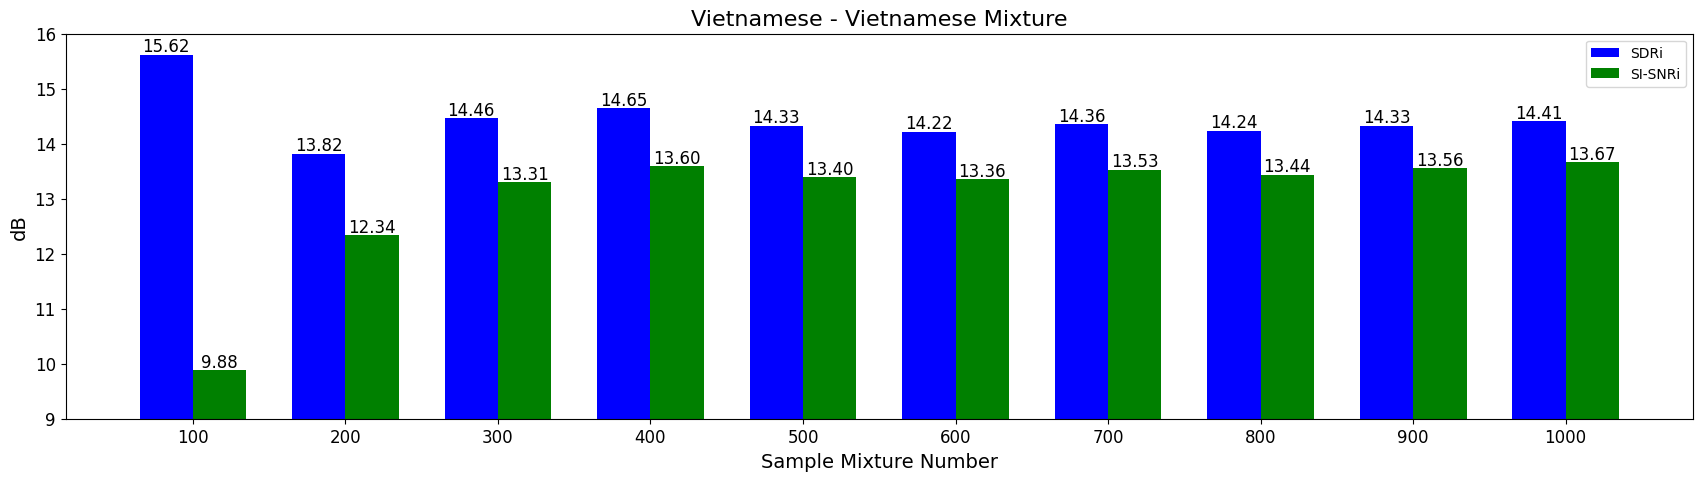

In [8]:


# Data from the table
samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sdr_values = [15.62, 13.82, 14.46, 14.65, 14.33, 14.22,14.36, 14.24, 14.33, 14.41]  # Added values to match the sample count
si_snr_values = [9.88, 12.34, 13.31, 13.60,  13.40, 13.36, 13.53,  13.44 ,13.56, 13.67 ]  # Added values to match the sample count

# Set up the plot
fig, ax = plt.subplots(figsize=(21, 5))

# Plot the SDRi and SI-SNRi bars
bar_width = 0.35  # Reduced bar width to avoid overlap
index = np.arange(len(samples))

# Bar positions
bar1 = ax.bar(index - bar_width/2, sdr_values, bar_width, label='SDRi', color='b')
bar2 = ax.bar(index + bar_width/2, si_snr_values, bar_width, label='SI-SNRi', color='g')

# Add labels and title
ax.set_xlabel('Sample Mixture Number', fontsize=14)
ax.set_ylabel('dB', fontsize=14)
ax.set_title('Vietnamese - Vietnamese Mixture', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(samples, fontsize=12)
ax.legend()

# Set the y-axis range from 12 to 14
ax.set_ylim(9, 16)

# Add numeric values above the bars
for i in range(len(samples)):
    ax.text(index[i] - bar_width/2, sdr_values[i] + 0.05, f'{sdr_values[i]:.2f}', ha='center', fontsize=12)
    ax.text(index[i] + bar_width/2, si_snr_values[i] + 0.05, f'{si_snr_values[i]:.2f}', ha='center', fontsize=12)

# Customize font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot to a PDF file
pdf_path = 'Vietnamese_Vietnamse_Mix.pdf'
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig)

# Notify that the file has been saved
print(f'Chart has been saved to: {pdf_path}')

Chart has been saved to: English_English_Mix.pdf


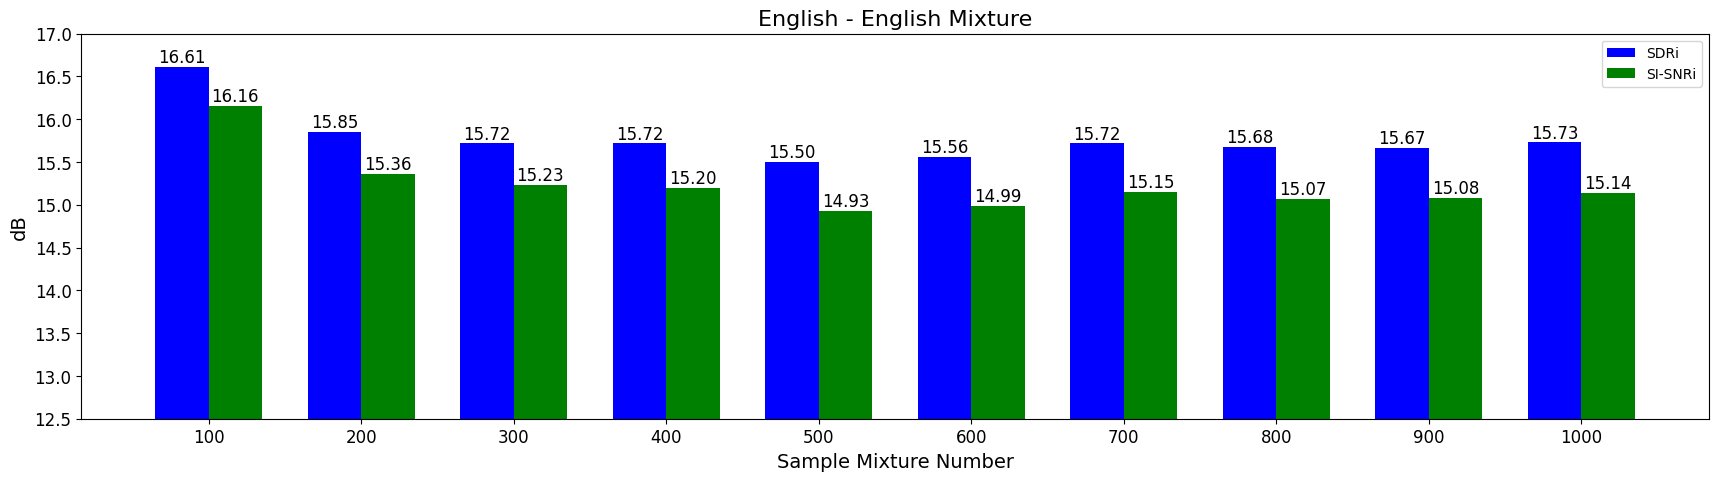

In [10]:
# Data from the table
samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sdr_values = [16.61, 15.85, 15.72, 15.72, 15.50, 15.56, 15.72 ,15.68 ,15.67,15.73]  # Added values to match the sample count
si_snr_values = [16.16, 15.36 ,15.23, 15.20, 14.93 ,14.99, 15.15,  15.07, 15.08, 15.14]  # Added values to match the sample count

# Set up the plot
fig, ax = plt.subplots(figsize=(21, 5))

# Plot the SDRi and SI-SNRi bars
bar_width = 0.35  # Reduced bar width to avoid overlap
index = np.arange(len(samples))

# Bar positions
bar1 = ax.bar(index - bar_width/2, sdr_values, bar_width, label='SDRi', color='b')
bar2 = ax.bar(index + bar_width/2, si_snr_values, bar_width, label='SI-SNRi', color='g')

# Add labels and title
ax.set_xlabel('Sample Mixture Number', fontsize=14)
ax.set_ylabel('dB', fontsize=14)
ax.set_title('English - English Mixture', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(samples, fontsize=12)
ax.legend()

# Set the y-axis range from 12 to 14
ax.set_ylim(12.5, 17)

# Add numeric values above the bars
for i in range(len(samples)):
    ax.text(index[i] - bar_width/2, sdr_values[i] + 0.05, f'{sdr_values[i]:.2f}', ha='center', fontsize=12)
    ax.text(index[i] + bar_width/2, si_snr_values[i] + 0.05, f'{si_snr_values[i]:.2f}', ha='center', fontsize=12)

# Customize font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot to a PDF file
pdf_path = 'English_English_Mix.pdf'
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig)

# Notify that the file has been saved
print(f'Chart has been saved to: {pdf_path}')

Chart has been saved to: Vietnamese_Vietnamese_Mix_halfduration.pdf


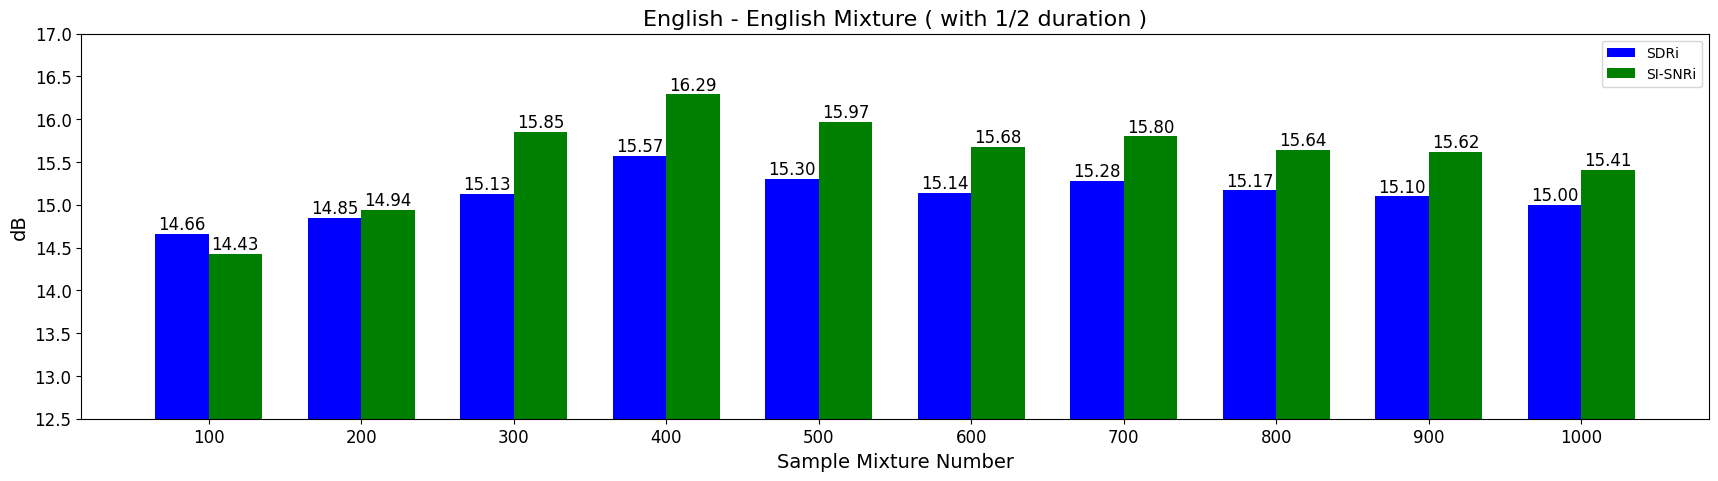

In [15]:
# Data from the table
samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
sdr_values = [14.66,14.85 ,15.13,15.57,15.30,15.14,15.28,15.17,15.10,15.00]  # Added values to match the sample count
si_snr_values = [14.43,14.94, 15.85,16.29,15.97,15.68,15.80,15.64,15.62,15.41,]  # Added values to match the sample count

# Set up the plot
fig, ax = plt.subplots(figsize=(21, 5))

# Plot the SDRi and SI-SNRi bars
bar_width = 0.35  # Reduced bar width to avoid overlap
index = np.arange(len(samples))

# Bar positions
bar1 = ax.bar(index - bar_width/2, sdr_values, bar_width, label='SDRi', color='b')
bar2 = ax.bar(index + bar_width/2, si_snr_values, bar_width, label='SI-SNRi', color='g')

# Add labels and title
ax.set_xlabel('Sample Mixture Number', fontsize=14)
ax.set_ylabel('dB', fontsize=14)
ax.set_title('English - English Mixture ( with 1/2 duration )', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(samples, fontsize=12)
ax.legend()

# Set the y-axis range from 12 to 14
ax.set_ylim(12.5, 17)

# Add numeric values above the bars
for i in range(len(samples)):
    ax.text(index[i] - bar_width/2, sdr_values[i] + 0.05, f'{sdr_values[i]:.2f}', ha='center', fontsize=12)
    ax.text(index[i] + bar_width/2, si_snr_values[i] + 0.05, f'{si_snr_values[i]:.2f}', ha='center', fontsize=12)

# Customize font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot to a PDF file
pdf_path = 'Vietnamese_Vietnamese_Mix_halfduration.pdf'
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig)

# Notify that the file has been saved
print(f'Chart has been saved to: {pdf_path}')

# Create SCP

In [8]:
root_dir = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/finetune_result_2_notrans/VIE-VIE-16K"
output_file = os.path.join(root_dir, "vie_vie_16k.scp")

with open(output_file, "w") as f_out:
    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue  # Bỏ qua nếu không phải thư mục

        # Lấy index từ tên thư mục: eng_mix_0000 → 0000
        if not folder.startswith("mix_"):
            continue  # bỏ qua thư mục không đúng pattern

        idx = folder.split("_")[-1]

        # Tạo đường dẫn file theo đúng tên thực tế
        mix_path = os.path.join(folder_path, f"mix_{idx}.wav")
        s1_path = os.path.join(folder_path, f"source1_{idx}.wav")
        s2_path = os.path.join(folder_path, f"source2_{idx}.wav")

        # Kiểm tra tồn tại đủ 3 file
        if os.path.exists(mix_path) and os.path.exists(s1_path) and os.path.exists(s2_path):
            f_out.write(f"{mix_path} {s1_path} {s2_path}\n")
        else:
            print(f"⚠️ Thiếu file trong {folder_path}")


In [1]:
from modelscope.hub.snapshot_download import snapshot_download

model_dir = snapshot_download('damo/speech_mossformer2_separation_temporal_8k', cache_dir='downloaded_models')

2025-09-24 21:10:55,361 - modelscope - INFO - PyTorch version 2.5.0+cu124 Found.
2025-09-24 21:10:55,364 - modelscope - INFO - Loading ast index from C:\Users\PhamManhKha\.cache\modelscope\ast_indexer
2025-09-24 21:10:55,464 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 a2f783d80c7dc959039f49947eab473e and a total number of 945 components indexed
2025-09-24 21:10:55,467 - modelscope - WARNING - Authentication has expired, please re-login if you need to access private models or datasets.
2025-09-24 21:10:58,535 - modelscope - WARNING - Model revision not specified, use revision: v0.9.0
Downloading: 100%|██████████| 231/231 [00:00<?, ?B/s] 
Downloading: 100%|██████████| 138k/138k [00:00<00:00, 250kB/s]
Downloading: 100%|██████████| 39.9k/39.9k [00:00<00:00, 210kB/s]
Downloading: 100%|██████████| 213M/213M [20:41<00:00, 180kB/s] 
Downloading: 100%|██████████| 2.85k/2.85k [00:00<?, ?B/s]


# .SCP File Validation 

In [10]:
import os

scp_path = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/finetune_result_2_notrans/VIE-VIE-16K/vie_vie_16k.scp"
missing_list = []

with open(scp_path, "r", encoding="utf-8") as f:
    for idx, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            mix_path, src1_path, src2_path = line.split()
        except ValueError:
            print(f"⚠️ Lỗi định dạng dòng {idx}: {line}")
            continue

        # Kiểm tra sự tồn tại
        if not os.path.exists(mix_path):
            missing_list.append((idx, "mix", mix_path))
        if not os.path.exists(src1_path):
            missing_list.append((idx, "src1", src1_path))
        if not os.path.exists(src2_path):
            missing_list.append((idx, "src2", src2_path))

# Báo kết quả
if missing_list:
    print(f"❌ Có {len(missing_list)} đường dẫn không tồn tại:")
    for i, typ, path in missing_list[:10]:  # in 10 dòng đầu tiên
        print(f"  - [Dòng {i}] {typ}: {path}")
    if len(missing_list) > 10:
        print(f"... và {len(missing_list) - 10} lỗi khác.")
else:
    print("✅ Tất cả đường dẫn trong file .scp đều hợp lệ!")

✅ Tất cả đường dẫn trong file .scp đều hợp lệ!


# Delete Files 

In [ ]:

root_dir = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data"

# ===== Tùy chọn =====
# Giữ lại file nào, xóa file nào
KEEP_KEYWORDS = ["_16k.wav"]  # chỉ giữ file có "_16k.wav"
DELETE_KEYWORDS = [".wav"]    # xóa các file .wav không có "_16k"

# ===== Duyệt toàn bộ thư mục =====
for folder in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)

        # Chỉ xét file .wav
        if not file.endswith(".wav"):
            continue

        # Nếu không chứa "_16k.wav" → xóa
        if not any(keep in file for keep in KEEP_KEYWORDS):
            print(f"🗑️ Xóa: {file_path}")
            os.remove(file_path)


In [ ]:

# ===== Thư mục gốc =====
root_dir = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/english_mix_data"

deleted_count = 0

# ===== Duyệt qua tất cả thư mục con =====
for folder in sorted(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    if not os.path.isdir(folder_path):
        continue  # Bỏ qua file lẻ

    # Duyệt qua toàn bộ file trong thư mục con
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav") and not filename.endswith("_16k.wav"):
            file_path = os.path.join(folder_path, filename)
            print("Sẽ xóa:", file_path)
            deleted_count += 1
            print(f"🗑️ Đã xóa: {file_path}")

print(f"\n✅ Đã xóa tổng cộng {deleted_count} file .wav gốc (không có '_16k').")


In [14]:
import os
import shutil

src = "/media/khapham/CodeAndDevtools/TaiLieu/2025 - 2026/TestMossFormer/finetune_result_2/ENG-ENG-16K"
dst = "/mnt/usb-Realtek_RTL9210B-CG_012345679039-0:0-part1/Datasets/finetune_result_22_notrans/ENG-ENG-16K"

for mix_folder in os.listdir(src):
    src_mix_path = os.path.join(src, mix_folder)
    dst_mix_path = os.path.join(dst, mix_folder)

    # bỏ qua nếu không phải thư mục
    if not os.path.isdir(src_mix_path):
        continue

    # tạo thư mục tương ứng bên destination nếu chưa có
    os.makedirs(dst_mix_path, exist_ok=True)

    # duyệt từng file trong mix_xxxx
    for file in os.listdir(src_mix_path):
        if file.endswith(".txt"):
            src_file = os.path.join(src_mix_path, file)
            dst_file = os.path.join(dst_mix_path, file)
            shutil.copy2(src_file, dst_file)

print("✅ Done! Copied all transcripts to finetune_result_2_notrans.")


✅ Done! Copied all transcripts to finetune_result_2_notrans.
